# VistaMart Colllective Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


Load the main csv containing the data for the VistaMart collective time series forecasting.

Since the data are not sorted, let's sort them by date and store first.

In [2]:
df = pd.read_csv('data/dataset.csv', parse_dates=['Date'], low_memory=False)

# Sort df by Date
df = df.sort_values(by=['Store', 'Date'])
display(df.head())

,Store,Date,Sales,Customers
843264,1,2013-01-02,5530,668
842155,1,2013-01-03,4327,578
841047,1,2013-01-04,4486,619
839940,1,2013-01-05,4997,635
838815,1,2013-01-07,7176,785


Let's load also the data for the individual stores and for the daily promotions.

In [3]:
stores = pd.read_csv('data/stores.csv')
display(stores.head())

,Store,Assortment,CompetitionDistance,PromoSinceWeek,PromoSinceYear,PromoInterval
0,1,Small,1270.0,NaN,NaN,NaN
1,2,Small,570.0,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,Small,14130.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,Large,620.0,NaN,NaN,NaN
4,5,Small,29910.0,NaN,NaN,NaN


In [4]:
promotions = pd.read_csv('data/promotions.csv', parse_dates=['Date'])
display(promotions.head())

,Store,Date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31


It is importa to visualize the data to understand the time series and the seasonality of the data.

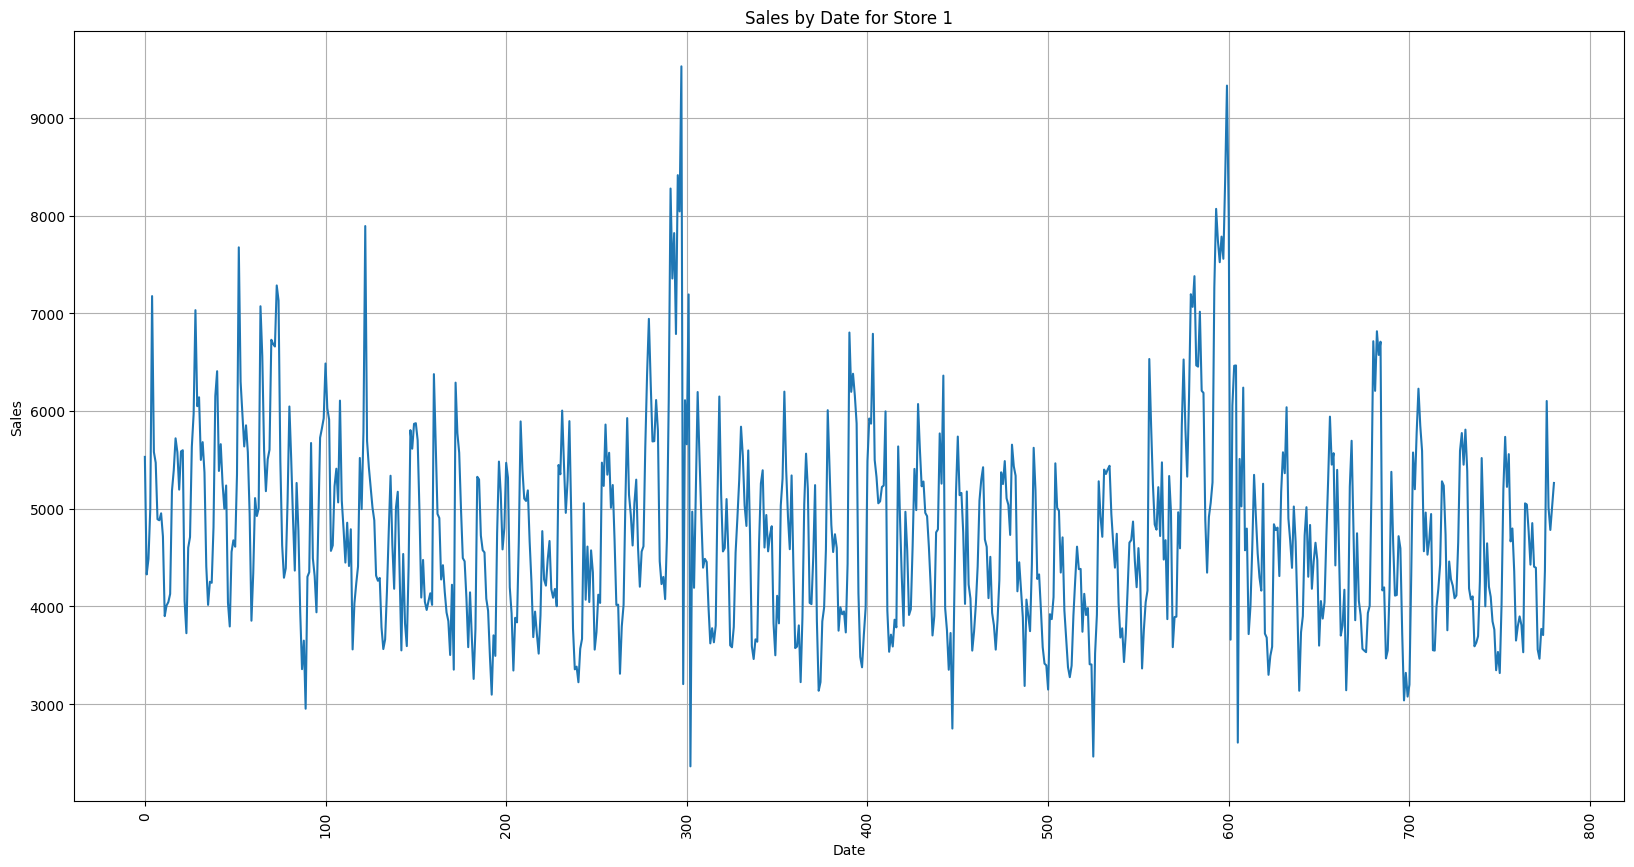

In [5]:
def plot_store_time_series(store_id, df):
    store_data = df[df['Store'] == store_id]
    x = np.arange(len(store_data['Date'].unique()))
    y = store_data.groupby('Date')['Sales'].sum()

    plt.figure(figsize=(20, 10))
    plt.plot(x, y)
    plt.title(f'Sales by Date for Store {store_id}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

plot_store_time_series(1, df)

We can start to analyze the data to see if there are any missing values, outliers, or other issues that need to be addressed before we can proceed with the forecasting.

In [6]:
def identify_nans(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    print(f"Columns with NaN values: {nan_columns}")
    for col in nan_columns:
        print(f"Column: {col}, Number of NaNs: {df[col].isna().sum()}")

identify_nans(df)

Columns with NaN values: []


In [7]:
def identify_outliers(train_df):
    df = train_df.copy()

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Store', 'Date'])
    window = 7

    df['rolling_mean'] = df.groupby('Store')['Sales'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    df['rolling_std'] = df.groupby('Store')['Sales'].transform(lambda x: x.rolling(window=window, min_periods=1).std())

    # Avoid division by zero (std can be 0 in early days)
    df['rolling_std'] = df['rolling_std'].replace(0, np.nan)

    df['z_score'] = (df['Sales'] - df['rolling_mean']) / df['rolling_std']
    df['is_outlier'] = df['z_score'].abs() > 2
    df.reset_index(drop=True, inplace=True)

    return df

outliers = identify_outliers(df)
display(outliers[outliers['is_outlier'] == True].head())

,Store,Date,Sales,Customers,rolling_mean,rolling_std,z_score,is_outlier
22,1,2013-01-28,4055,549,5303.714286,576.494208,-2.166048,True
52,1,2013-03-04,7675,840,4957.428571,1297.239358,2.094888,True
64,1,2013-03-18,7072,778,5035.857143,1004.487669,2.027046,True
103,1,2013-05-06,4568,562,5780.714286,587.570057,-2.063948,True
115,1,2013-05-22,3559,507,4562.571429,500.432099,-2.005410,True


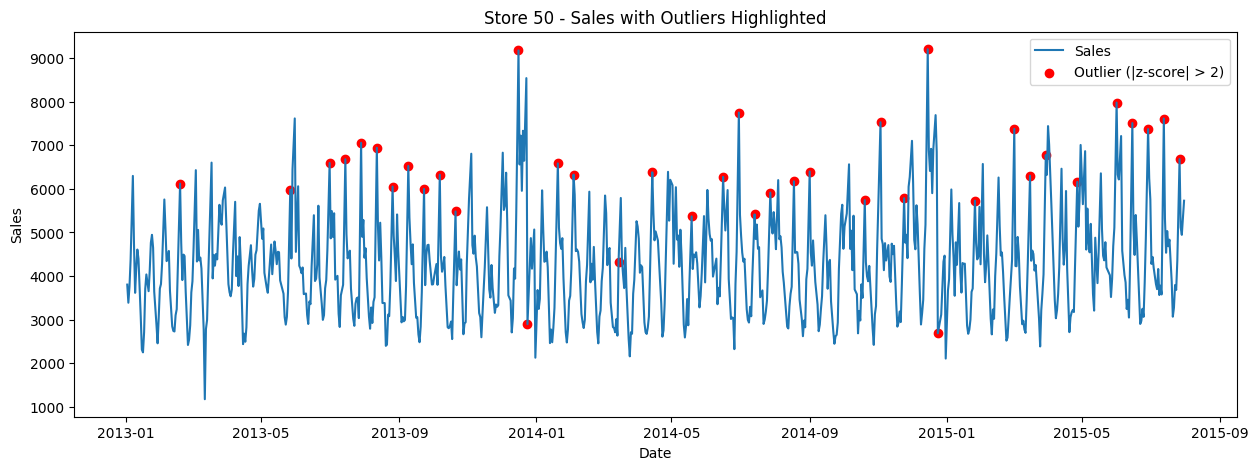

In [8]:
def plot_outliers(store_id, outliers):
    # Use df, which contains z_score and is_outlier columns
    store_data = outliers[outliers['Store'] == store_id].copy()
    plt.figure(figsize=(15, 5))
    plt.plot(store_data['Date'], store_data['Sales'], label='Sales')
    # Plot outliers (z_score > 2 or < -2)
    outlier_mask = store_data['is_outlier']
    plt.scatter(store_data.loc[outlier_mask, 'Date'], 
                store_data.loc[outlier_mask, 'Sales'], 
                color='red', label='Outlier (|z-score| > 2)')
    plt.legend()
    plt.title(f"Store {store_id} - Sales with Outliers Highlighted")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

plot_outliers(50, outliers)

We have access to singular day promotions, but we need to convert also the periodic promotions into a similar format.

In [9]:
def get_promo_dates(stores_df: pd.DataFrame) -> pd.DataFrame:
    stores_df = stores_df.copy()
    stores_df = stores_df.dropna(subset=['PromoInterval', 'PromoSinceYear', 'PromoSinceWeek'])

    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
        'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    promo_rows = []
    for _, row in stores_df.iterrows():
        store_id = row['Store']
        promo_year = int(row['PromoSinceYear'])
        promo_week = int(row['PromoSinceWeek'])
        months = [m.strip() for m in row['PromoInterval'].split(',')]

        promo_start_date = pd.to_datetime(f'{promo_year}-W{int(promo_week):02d}-1', format='%Y-W%W-%w')

        for year in range(promo_year, 2016):
            for month in months:
                month_num = month_map[month]
                promo_date = pd.Timestamp(year=year, month=month_num, day=1)

                if promo_date >= promo_start_date:
                    month_dates = pd.date_range(start=promo_date, end=promo_date + pd.offsets.MonthEnd(0), freq='D')
                    for d in month_dates:
                        promo_rows.append({'Store': store_id, 'Date': pd.to_datetime(d)})

    promo_df = pd.DataFrame(promo_rows)
    return promo_df

promo_dates_df = get_promo_dates(stores)
display(promo_dates_df)

,Store,Date
0,2,2010-04-01
1,2,2010-04-02
2,2,2010-04-03
3,2,2010-04-04
4,2,2010-04-05
...,...,...
256755,1115,2015-12-27
256756,1115,2015-12-28
256757,1115,2015-12-29
256758,1115,2015-12-30


Now we have to add the periodic promotions to the datafram of the daily promotions.

In [10]:
# Add promo_dates_df to promotions
promotions = pd.merge(promotions, promo_dates_df, on=['Store', 'Date'], how='outer')
promotions = promotions.drop_duplicates(subset=['Store', 'Date'])
promotions = promotions.sort_values(by=['Store', 'Date'])
display(promotions)

,Store,Date
0,1,2013-01-07
1,1,2013-01-08
2,1,2013-01-09
3,1,2013-01-10
4,1,2013-01-11
...,...,...
577877,1115,2015-12-27
577878,1115,2015-12-28
577879,1115,2015-12-29
577880,1115,2015-12-30


We can merge the main df with the stores one to add the info regarding the stores to the main df.

In [11]:
# Merge stores with df
df = pd.merge(df, stores, on='Store', how='left')
display(df)

,Store,Date,Sales,Customers,Assortment,CompetitionDistance,PromoSinceWeek,PromoSinceYear,PromoInterval
0,1,2013-01-02,5530,668,Small,1270.0,NaN,NaN,NaN
1,1,2013-01-03,4327,578,Small,1270.0,NaN,NaN,NaN
2,1,2013-01-04,4486,619,Small,1270.0,NaN,NaN,NaN
3,1,2013-01-05,4997,635,Small,1270.0,NaN,NaN,NaN
4,1,2013-01-07,7176,785,Small,1270.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
844387,1115,2015-07-27,10712,608,Large,5350.0,22.0,2012.0,"Mar,Jun,Sept,Dec"
844388,1115,2015-07-28,8093,500,Large,5350.0,22.0,2012.0,"Mar,Jun,Sept,Dec"
844389,1115,2015-07-29,7661,473,Large,5350.0,22.0,2012.0,"Mar,Jun,Sept,Dec"
844390,1115,2015-07-30,8405,502,Large,5350.0,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [12]:
df.drop(columns=['PromoSinceWeek', 'PromoSinceYear', 'PromoInterval'], inplace=True)
display(df)

,Store,Date,Sales,Customers,Assortment,CompetitionDistance
0,1,2013-01-02,5530,668,Small,1270.0
1,1,2013-01-03,4327,578,Small,1270.0
2,1,2013-01-04,4486,619,Small,1270.0
3,1,2013-01-05,4997,635,Small,1270.0
4,1,2013-01-07,7176,785,Small,1270.0
...,...,...,...,...,...,...
844387,1115,2015-07-27,10712,608,Large,5350.0
844388,1115,2015-07-28,8093,500,Large,5350.0
844389,1115,2015-07-29,7661,473,Large,5350.0
844390,1115,2015-07-30,8405,502,Large,5350.0


We can also add all the promotions dates to the main df but giving priority to the existence of a main df entry with the same date and store id on the promotions df.

In [13]:
# Merge df with promotions on 'Store' and 'Date', keeping only rows present in df
df = pd.merge(df, promotions, on=['Store', 'Date'], how='left', indicator='promo_merge')
df['Promo'] = (df['promo_merge'] == 'both').astype(int)
df.drop(columns=['promo_merge'], inplace=True)
display(df)

,Store,Date,Sales,Customers,Assortment,CompetitionDistance,Promo
0,1,2013-01-02,5530,668,Small,1270.0,0
1,1,2013-01-03,4327,578,Small,1270.0,0
2,1,2013-01-04,4486,619,Small,1270.0,0
3,1,2013-01-05,4997,635,Small,1270.0,0
4,1,2013-01-07,7176,785,Small,1270.0,1
...,...,...,...,...,...,...,...
844387,1115,2015-07-27,10712,608,Large,5350.0,1
844388,1115,2015-07-28,8093,500,Large,5350.0,1
844389,1115,2015-07-29,7661,473,Large,5350.0,1
844390,1115,2015-07-30,8405,502,Large,5350.0,1


In [14]:
identify_nans(df)

Columns with NaN values: ['CompetitionDistance']
Column: CompetitionDistance, Number of NaNs: 2186


There are some missing values in the main df, but this is not a problem since we can fill them.

In [15]:
df.fillna(0, inplace=True)
identify_nans(df)

Columns with NaN values: []


It could be better to add the day of the week and the month as integers to the main df, since they could be useful for the forecasting.

In [16]:
# Add day of week as a integer
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Add month as a integer
df['Month'] = df['Date'].dt.month
display(df)

,Store,Date,Sales,Customers,Assortment,CompetitionDistance,Promo,DayOfWeek,Month
0,1,2013-01-02,5530,668,Small,1270.0,0,2,1
1,1,2013-01-03,4327,578,Small,1270.0,0,3,1
2,1,2013-01-04,4486,619,Small,1270.0,0,4,1
3,1,2013-01-05,4997,635,Small,1270.0,0,5,1
4,1,2013-01-07,7176,785,Small,1270.0,1,0,1
...,...,...,...,...,...,...,...,...,...
844387,1115,2015-07-27,10712,608,Large,5350.0,1,0,7
844388,1115,2015-07-28,8093,500,Large,5350.0,1,1,7
844389,1115,2015-07-29,7661,473,Large,5350.0,1,2,7
844390,1115,2015-07-30,8405,502,Large,5350.0,1,3,7


We can visualize the correlation between Sales and Customers. 
We can also calculate the pd.corr value, a value of 1 means perfect positive correlation, -1 means perfect negative correlation and 0 means no correlation

Correlation between Sales and Customers: 0.82


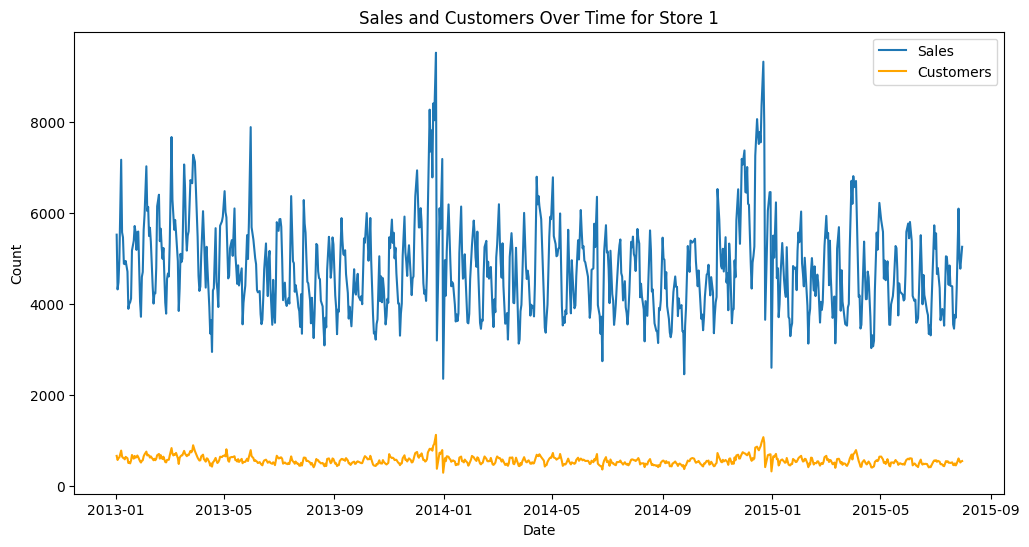

In [17]:
correlation = df["Sales"].corr(df["Customers"])
print(f"Correlation between Sales and Customers: {correlation:.2f}")

def plot_sales_vs_customers(df, store):
    store_df = df[df['Store'] == store]
    plt.figure(figsize=(12, 6))
    plt.plot(store_df['Date'], store_df['Sales'], label='Sales')
    plt.plot(store_df['Date'], store_df['Customers'], label='Customers', color='orange')
    plt.title(f'Sales and Customers Over Time for Store {store}')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

plot_sales_vs_customers(df, 1)

We can also visualize sales by weekday and by month, to understand how they're distributed

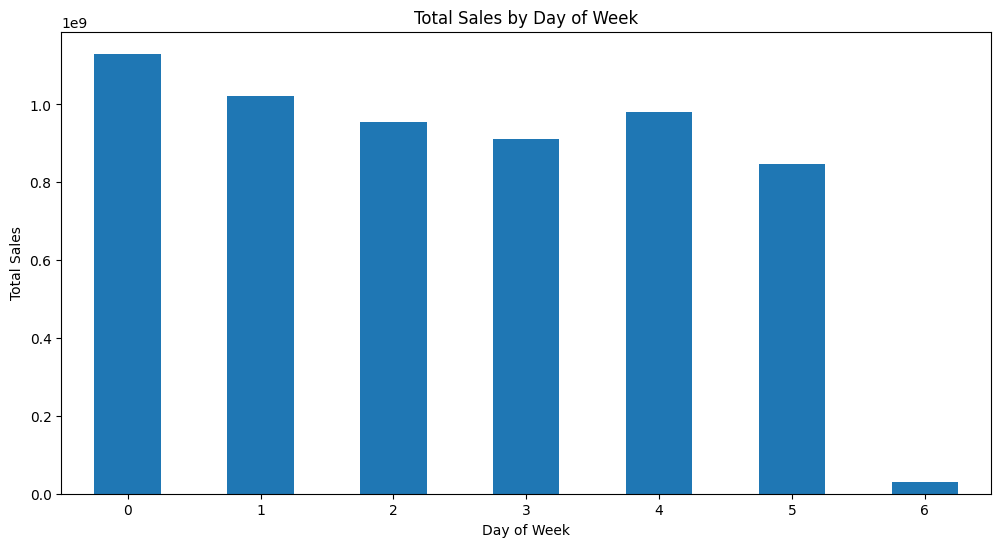

In [18]:
plt.figure(figsize=(12, 6))
df.groupby('DayOfWeek')['Sales'].sum().plot(kind='bar')
plt.title('Total Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.show()

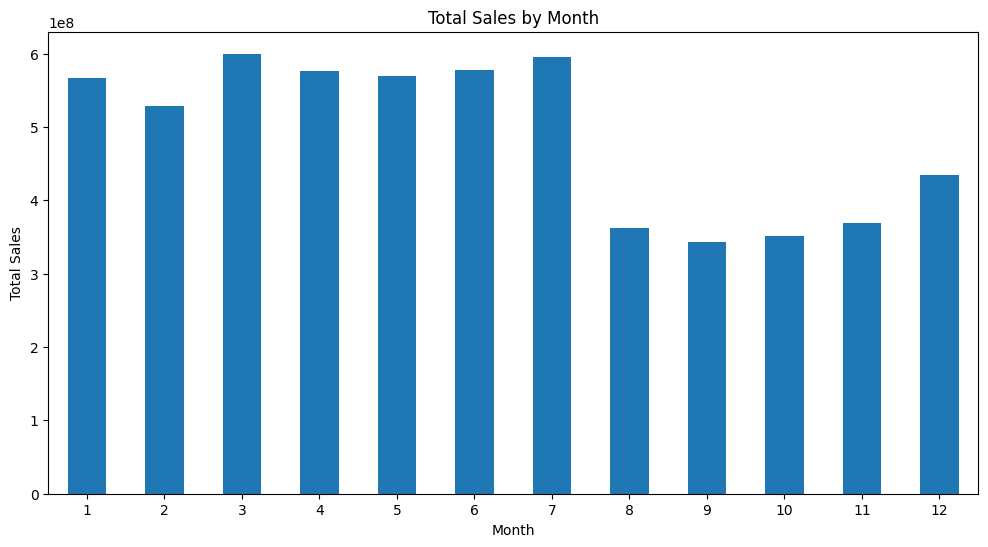

In [19]:
plt.figure(figsize=(12, 6))
df.groupby('Month')['Sales'].sum().plot(kind='bar')
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.show()

Another important thing to do is to convert the Assortment in a correct format, since it is a categorical variable, we need to convert it to a numerical variable for the forecasting.

In [20]:
encoder = LabelEncoder()
df['Assortment'] = encoder.fit_transform(df['Assortment'])

print(encoder.inverse_transform([0, 1, 2]))
display(df.head())

['Large' 'Medium' 'Small']


,Store,Date,Sales,Customers,Assortment,CompetitionDistance,Promo,DayOfWeek,Month
0,1,2013-01-02,5530,668,2,1270.0,0,2,1
1,1,2013-01-03,4327,578,2,1270.0,0,3,1
2,1,2013-01-04,4486,619,2,1270.0,0,4,1
3,1,2013-01-05,4997,635,2,1270.0,0,5,1
4,1,2013-01-07,7176,785,2,1270.0,1,0,1


The df contains a Customers columns which represents the number of customers for each store and date. This column is a sort of data leakage, since it is not available at the time of the prediction. We need to drop this column from the df.

In [21]:
df.drop(columns=['Customers'], inplace=True)

Since we are going to use XGBoost for the forecasting, we need to add some additional features to the df, such as the lagged values of the Sales and the rolling mean of the Sales.

In [22]:
# Features Engineering
lags = [1, 7, 14]
ma = [7, 14]
std = [7, 14]

# Adding Lag Features
for lag in lags:
    df[f'Sales_lag_{lag}'] = df.groupby('Store')['Sales'].shift(lag)
df = df.dropna(subset=[f'Sales_lag_{lag}' for lag in lags]).copy()

# Adding Rolling mean features
for ma_window in ma:
    df.loc[:, f'Sales_ma_{ma_window}'] = (
        df.groupby('Store')['Sales']
        .apply(lambda x: x.shift(1).rolling(window=ma_window).mean())
        .values
    )
df = df.dropna(subset=[f'Sales_ma_{ma_window}' for ma_window in ma]).copy()

# Adding Rolling std features
for std_window in std:
    df.loc[:, f'Sales_std_{std_window}'] = (
        df.groupby('Store')['Sales']
        .apply(lambda x: x.shift(1).rolling(window=std_window).std())
        .values
    )
df = df.dropna(subset=[f'Sales_ma_{ma_window}' for ma_window in ma]).copy()

In [23]:
display(df.head())

,Store,Date,Sales,Assortment,CompetitionDistance,Promo,DayOfWeek,Month,Sales_lag_1,Sales_lag_7,Sales_lag_14,Sales_ma_7,Sales_ma_14,Sales_std_7,Sales_std_14
28,1,2013-02-04,7032,2,1270.0,1,0,2,5970.0,5598.0,4127.0,4898.714286,5076.642857,NaN,NaN
29,1,2013-02-05,6049,2,1270.0,1,1,2,7032.0,4055.0,5182.0,5103.571429,5284.142857,NaN,NaN
30,1,2013-02-06,6140,2,1270.0,1,2,2,6049.0,3725.0,5394.0,5388.428571,5346.071429,NaN,NaN
31,1,2013-02-07,5499,2,1270.0,1,3,2,6140.0,4601.0,5720.0,5733.428571,5399.357143,NaN,NaN
32,1,2013-02-08,5681,2,1270.0,1,4,2,5499.0,4709.0,5578.0,5861.714286,5383.571429,NaN,NaN


We finished the preprocessing of the data, now we can split the data into train and test sets.

In [24]:
def split_dataset(df):
    df = df.copy()
    train = df[df['Date'] < '2015-03-01']
    test = df[df['Date'] >= '2015-03-01']

    X_train, y_train = train.drop(columns='Sales'), train['Sales']
    X_test, y_test = test.drop(columns='Sales'), test['Sales']

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = split_dataset(df)

It is important to find the best parameters for the XGBoost model, so we can use Optuna to find the best parameters which could minimize the RMSE.

In [ ]:
import optuna

def objectiveXGB(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
    }

    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    X_train_copy.drop(columns=['Date'], inplace=True)
    X_test_copy.drop(columns=['Date'], inplace=True)

    model = XGBRegressor(**params)
    model.fit(X_train_copy, y_train)
    
    preds = model.predict(X_test_copy)
    rmse = root_mean_squared_error(y_test, preds)
    
    return rmse

def objectiveLR(trial):
    params = {
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
    }

    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    X_train_copy.drop(columns=['Date'], inplace=True)
    X_test_copy.drop(columns=['Date'], inplace=True)

    X_train_copy.fillna(0, inplace=True)

    model = LinearRegression(**params)
    model.fit(X_train_copy, y_train)

    preds = model.predict(X_test_copy)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse

def objectiveProphet(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 0.5),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10.0),
    }

    df_prophet = X_train.copy()
    df_prophet['Sales'] = y_train

    df_prophet = df_prophet[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
    model = Prophet(**params)
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=len(X_test), freq='D')
    forecast = model.predict(future)

    preds = forecast['yhat'][-len(X_test):].values
    rmse = root_mean_squared_error(y_test, preds)

    return rmse

In [ ]:
import json

try:
    with open('best_params.json', 'r') as f:
        best_params = json.load(f)
except FileNotFoundError:
    best_params = {}

if 'xgb' not in best_params:
    study_xgb = optuna.create_study(direction='minimize')
    study_xgb.optimize(objectiveXGB, n_trials=50)
    best_params['xgb'] = study_xgb.best_params

[I 2025-05-26 14:45:07,139] A new study created in memory with name: no-name-d8b3b1d0-ec7b-4b6b-a444-9a96e8e02903
[I 2025-05-26 14:45:18,436] Trial 0 finished with value: 1215.2914496091955 and parameters: {'n_estimators': 342, 'max_depth': 4, 'learning_rate': 0.025633998303402357, 'subsample': 0.8936370031541867, 'colsample_bytree': 0.992058080979118, 'min_child_weight': 4, 'gamma': 0.30194748839843855, 'reg_alpha': 4.868413905666114, 'reg_lambda': 4.544298971891411}. Best is trial 0 with value: 1215.2914496091955.
[I 2025-05-26 14:45:26,339] Trial 1 finished with value: 1177.897457257075 and parameters: {'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.2391292574331931, 'subsample': 0.9096430628194182, 'colsample_bytree': 0.5590792007321279, 'min_child_weight': 2, 'gamma': 1.3660153049734696, 'reg_alpha': 1.4288208358436267, 'reg_lambda': 3.4332629106336965}. Best is trial 1 with value: 1177.897457257075.
[I 2025-05-26 14:45:36,142] Trial 2 finished with value: 1054.3198146478

TypeError: LinearRegression.__init__() got an unexpected keyword argument 'normalize'

Now we can train the model with the best parameters found by Optuna and make the predictions for the test set.

In [ ]:
if 'lr' not in best_params:
    study_lr = optuna.create_study(direction='minimize')
    study_lr.optimize(objectiveLR, n_trials=2)
    best_params['lr'] = study_lr.best_params

[I 2025-05-26 15:17:49,624] A new study created in memory with name: no-name-6d08511b-513a-4ff4-8067-d7f6a32b1363
[I 2025-05-26 15:17:50,054] Trial 0 finished with value: 1472.8766670206774 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 1472.8766670206774.
[I 2025-05-26 15:17:50,402] Trial 1 finished with value: 1473.3309695917428 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 1472.8766670206774.
[I 2025-05-26 15:17:50,734] Trial 2 finished with value: 1473.3309695917428 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 1472.8766670206774.
[I 2025-05-26 15:17:51,100] Trial 3 finished with value: 1472.8766670206774 and parameters: {'fit_intercept': True}. Best is trial 0 with value: 1472.8766670206774.
[I 2025-05-26 15:17:51,436] Trial 4 finished with value: 1473.3309695917428 and parameters: {'fit_intercept': False}. Best is trial 0 with value: 1472.8766670206774.
[I 2025-05-26 15:17:51,768] Trial 5 finished with value: 1

In [36]:
if 'prophet' not in best_params:
    study_prophet = optuna.create_study(direction='minimize')
    study_prophet.optimize(objectiveProphet, n_trials=10)
    best_params['prophet'] = study_prophet.best_params

print("Best parameters:")
for model, params in best_params.items():
    print(f"{model}: {params}")

[I 2025-05-26 15:19:43,849] A new study created in memory with name: no-name-0afd6776-7e0f-4905-a78d-56b6cab2bc0d
15:20:04 - cmdstanpy - INFO - Chain [1] start processing
15:26:34 - cmdstanpy - INFO - Chain [1] done processing
[W 2025-05-26 15:26:36,329] Trial 0 failed with parameters: {'changepoint_prior_scale': 0.2988130642826617, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.413873551440767} because of the following error: OutOfBoundsDatetime('Cannot generate range with start=1425081600000000000 and periods=140503').
Traceback (most recent call last):
  File "c:\Users\giuseppe.bellamacina\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\giuseppe.bellamacina\AppData\Local\Temp\ipykernel_9964\1290448169.py", line 68, in objectiveProphet
    future = model.make_future_dataframe(periods=len(X_test), freq='D')
             

OutOfBoundsDatetime: Cannot generate range with start=1425081600000000000 and periods=140503

In [ ]:
# XGBoost
xgb_params = best_params['xgb'].copy()
xgb_params['tree_method'] = 'hist'
xgb_params['random_state'] = 42
xgb_params['n_jobs'] = -1

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_train_copy.drop(columns=['Date'], inplace=True)
X_test_copy.drop(columns=['Date'], inplace=True)

xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train_copy, y_train, eval_set=[(X_test_copy, y_test)], verbose=False)
y_pred_xgb = xgb_model.predict(X_test_copy)
y_pred_xgb = np.clip(y_pred_xgb, 0, None)

# Linear Regression
lr_params = best_params['lr'].copy()
lr_model = LinearRegression(**lr_params)
lr_model.fit(X_train_copy, y_train)
y_pred_lr = lr_model.predict(X_test_copy)
y_pred_lr = np.clip(y_pred_lr, 0, None)

# Prophet
prophet_params = best_params['prophet'].copy()
df_prophet = X_train.copy()
df_prophet['Sales'] = y_train
df_prophet = df_prophet[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
prophet_model = Prophet(**prophet_params)
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=len(X_test), freq='D')
forecast = prophet_model.predict(future)
y_pred_prophet = forecast['yhat'][-len(X_test):].values
y_pred_prophet = np.clip(y_pred_prophet, 0, None)

KeyError: 'lr'

We can also calculate the RMSE for the test set and plot the predictions vs the actual values.

In [ ]:
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
rmse_prophet = root_mean_squared_error(y_test, y_pred_prophet)

mean_sales = y_test.mean()
pct_xgb = 100 * rmse_xgb / mean_sales
pct_lr = 100 * rmse_lr / mean_sales
pct_prophet = 100 * rmse_prophet / mean_sales

print(f"XGBoost Test RMSE: {rmse_xgb:.2f} ({pct_xgb:.2f}% of mean sales)")
print(f"Linear Regression Test RMSE: {rmse_lr:.2f} ({pct_lr:.2f}% of mean sales)")
print(f"Prophet Test RMSE: {rmse_prophet:.2f} ({pct_prophet:.2f}% of mean sales)")

In [ ]:
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(14,6))
    plt.plot(y_test.values, label='Actual Sales')
    plt.plot(y_pred, label='Predicted Sales')
    plt.title(title)
    plt.xlabel('Sample Index (time ordered)')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()
    
n1 = 0
n2 = 100

plot_actual_vs_predicted(y_test[n1:n2], y_pred_xgb[n1:n2], 'XGBoost: Actual vs Predicted Sales')
plot_actual_vs_predicted(y_test[n1:n2], y_pred_lr[n1:n2], 'Linear Regression: Actual vs Predicted Sales')
plot_actual_vs_predicted(y_test[n1:n2], y_pred_prophet[n1:n2], 'Prophet: Actual vs Predicted Sales')

In [ ]:
with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)